# Import Library

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import pickle
import json
import joblib
from tensorflow.keras.models import load_model

# Load Data 

In [41]:
print("--- Memulai Pipeline Deteksi Anemia ---")

df = pd.read_excel('/dataset/anemia_data.xlsx')

--- Memulai Pipeline Deteksi Anemia ---


# Data Understanding

In [42]:
print(f"\nBentuk dataset: {df.shape}")
print("\nInformasi umum dataset:")
df.info()


Bentuk dataset: (15300, 29)

Informasi umum dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15300 entries, 0 to 15299
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GENDER               15300 non-null  int64  
 1   WBC                  15300 non-null  float64
 2   NE#                  15300 non-null  float64
 3   LY#                  15300 non-null  float64
 4   MO#                  15300 non-null  float64
 5   EO#                  15300 non-null  float64
 6   BA#                  15300 non-null  float64
 7   RBC                  15300 non-null  float64
 8   HGB                  15300 non-null  float64
 9   HCT                  15300 non-null  float64
 10  MCV                  15300 non-null  float64
 11  MCH                  15300 non-null  float64
 12  MCHC                 15300 non-null  float64
 13  RDW                  15300 non-null  float64
 14  PLT                  15300 non-n

In [43]:
print("\nLima baris pertama dataset:")
print(df.head())


Lima baris pertama dataset:
   GENDER    WBC   NE#   LY#   MO#   EO#   BA#   RBC   HGB   HCT  .   SDTSD  \
0       1  10.63  6.31  2.79  0.91  0.56  0.06  4.31  12.7  37.6  .  248.90   
1       1   5.08  2.50  1.87  0.43  0.26  0.02  4.34  12.8  36.9  .  348.48   
2       1  13.68  9.40  2.69  1.55  0.03  0.01  3.18   9.4  27.5  .  357.27   
3       1   5.60  3.94  0.83  0.54  0.26  0.03  3.35  10.5  31.4  .  360.60   
4       1   3.57  2.03  1.25  0.10  0.18  0.01  1.31   5.1  14.3  .  223.28   

         TSD  FERRITTE  FOLATE    B12  All_Class  HGB_Anemia_Class  \
0  40.176778    194.00    5.06  178.2          4                 0   
1  33.482553     57.37    9.88  197.7          4                 0   
2  20.144429    114.20    8.37  143.0          4                 0   
3  27.731559    214.20    6.39  139.9          4                 0   
4  78.860623    303.40    4.30   50.0          4                 0   

   Iron_anemia_Class  Folate_anemia_class  B12_Anemia_class  
0            

In [44]:
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
GENDER                 0
WBC                    0
NE#                    0
LY#                    0
MO#                    0
EO#                    0
BA#                    0
RBC                    0
HGB                    0
HCT                    0
MCV                    0
MCH                    0
MCHC                   0
RDW                    0
PLT                    0
MPV                    0
PCT                    0
PDW                    0
SD                     0
SDTSD                  0
TSD                    0
FERRITTE               0
FOLATE                 0
B12                    0
All_Class              0
HGB_Anemia_Class       0
Iron_anemia_Class      0
Folate_anemia_class    0
B12_Anemia_class       0
dtype: int64


# Data Preparation

In [45]:
original_target_column = 'All_Class'
new_target_column = 'Anemia_Status'

In [46]:
# Penanganan nilai yang hilang
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].astype(str).mode()[0], inplace=True)
print("Penanganan nilai hilang selesai.")

Penanganan nilai hilang selesai.


In [47]:
# Menggabungkan 4 label asli menjadi 2: "Terkena Anemia" (1) dan "Tidak Terkena Anemia" (0)
# Asumsi: 0 = "No Anemia", lainnya (1,2,3,4) = Terkena Anemia
df[new_target_column] = df[original_target_column].apply(lambda x: 0 if x == 0 else 1)

In [48]:
print(f"\nDistribusi label baru '{new_target_column}':")
print(df[new_target_column].value_counts())
print(f"Mapping label baru: 0 = 'Tidak Terkena Anemia', 1 = 'Terkena Anemia'")


Distribusi label baru 'Anemia_Status':
Anemia_Status
0    9747
1    5553
Name: count, dtype: int64
Mapping label baru: 0 = 'Tidak Terkena Anemia', 1 = 'Terkena Anemia'


# Exploratory Data Analysis (EDA)

/tmp/ipykernel_37223/2727475760.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=new_target_column, data=df, palette='viridis')


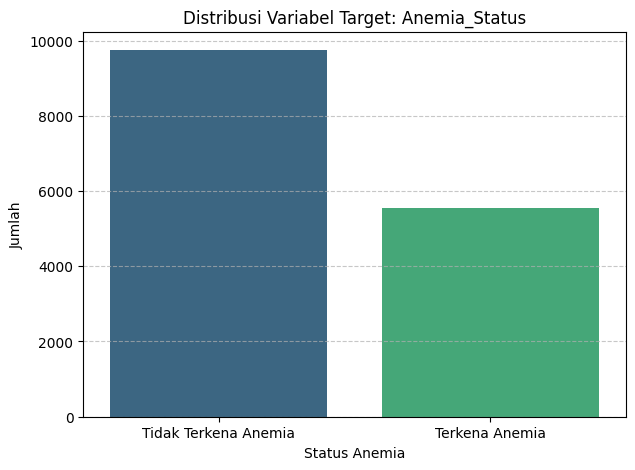

In [49]:
plt.figure(figsize=(7, 5))
sns.countplot(x=new_target_column, data=df, palette='viridis')
plt.title(f'Distribusi Variabel Target: {new_target_column}')
plt.xlabel('Status Anemia')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Tidak Terkena Anemia', 'Terkena Anemia'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

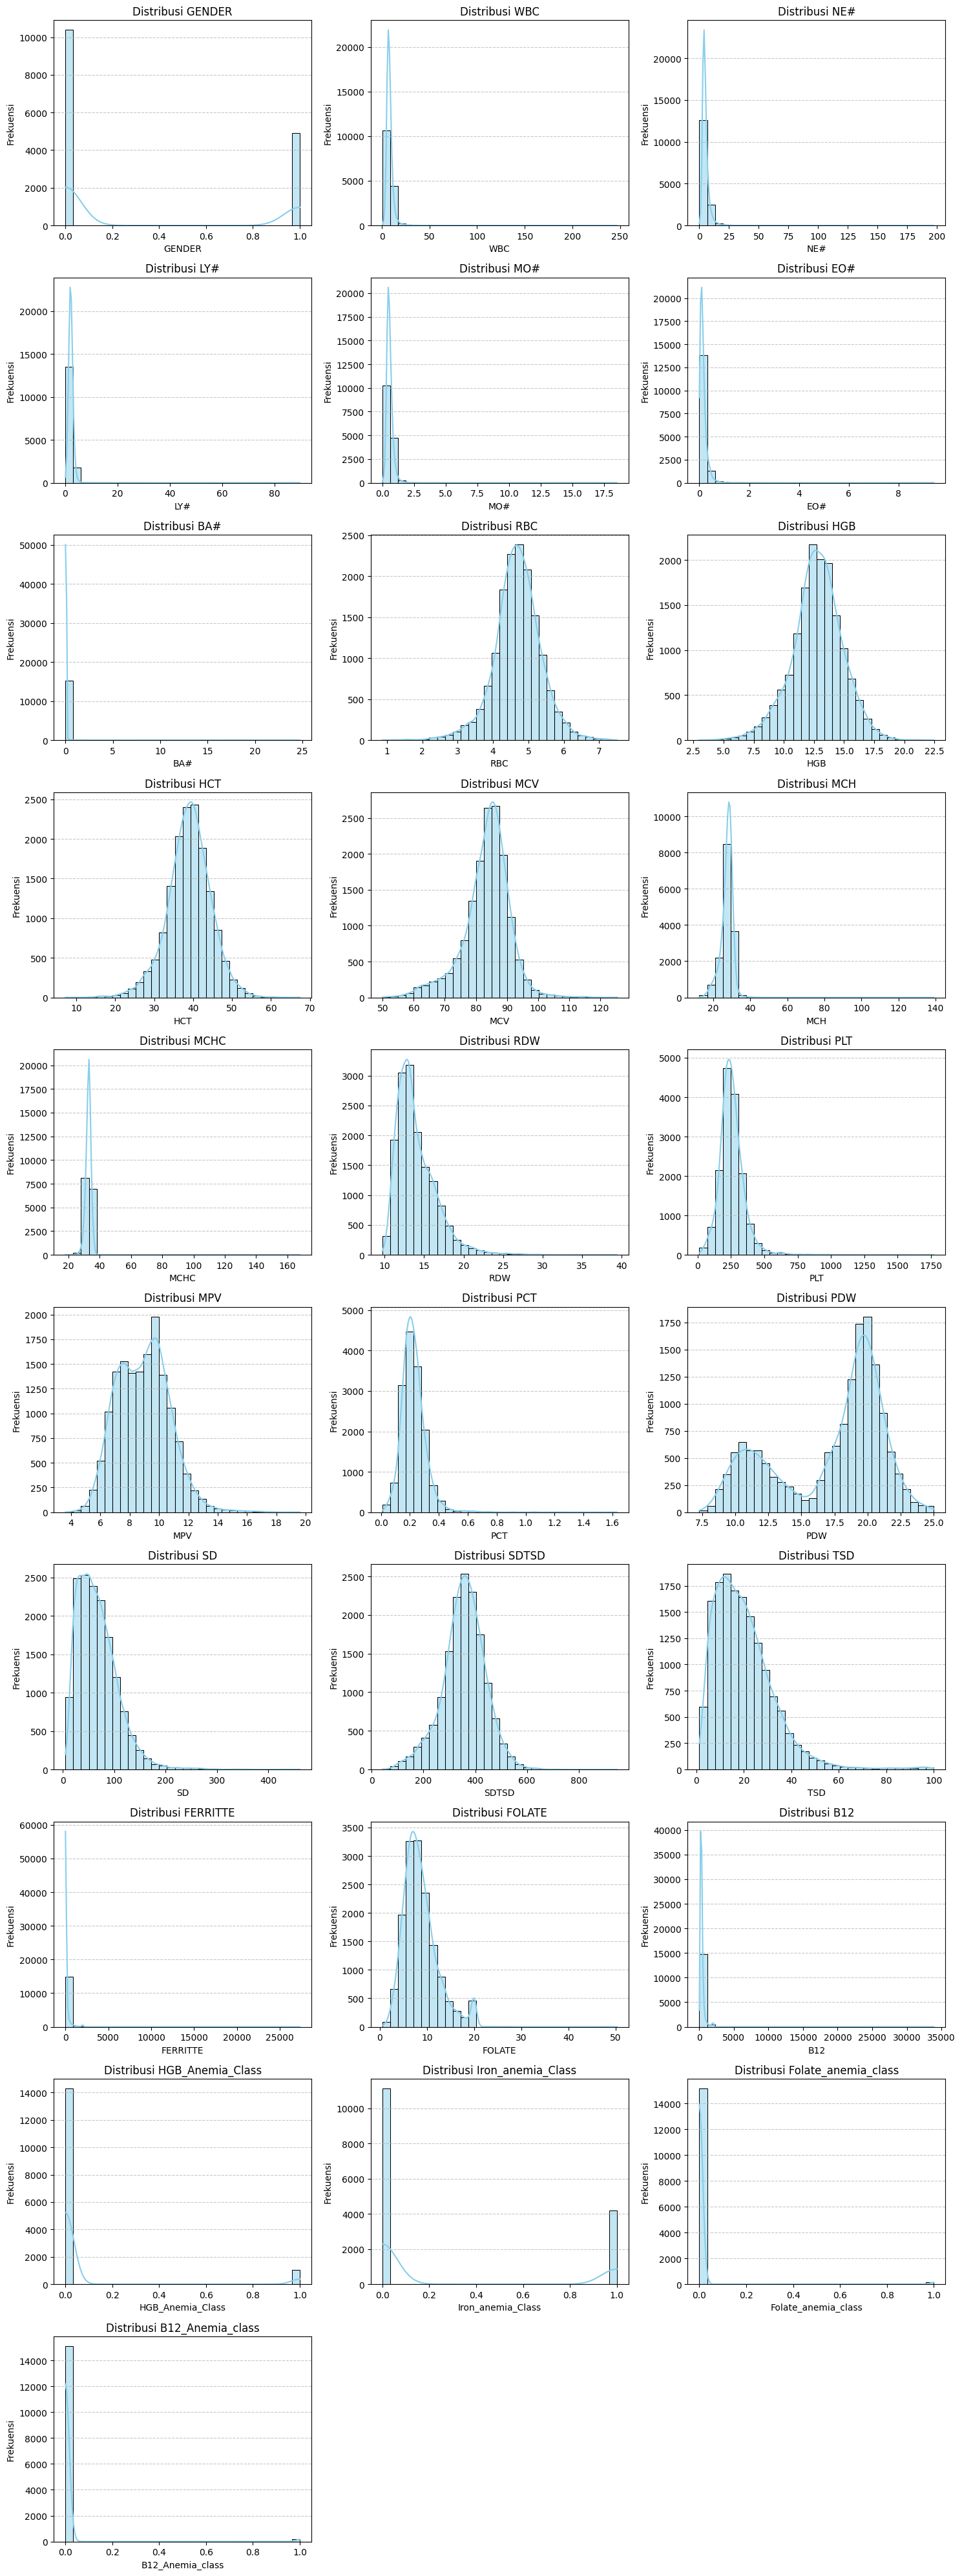

In [50]:
# Plot distribusi fitur numerik (opsional, bisa dihilangkan jika terlalu banyak plot)
numeric_cols_eda = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if original_target_column in numeric_cols_eda:
    numeric_cols_eda.remove(original_target_column)
if new_target_column in numeric_cols_eda:
    numeric_cols_eda.remove(new_target_column)

if len(numeric_cols_eda) > 0:
    n_cols = 3
    n_rows = (len(numeric_cols_eda) + n_cols - 1) // n_cols
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    for i, col in enumerate(numeric_cols_eda):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribusi {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frekuensi', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kolom numerik untuk diplot distribusinya (selain target).")

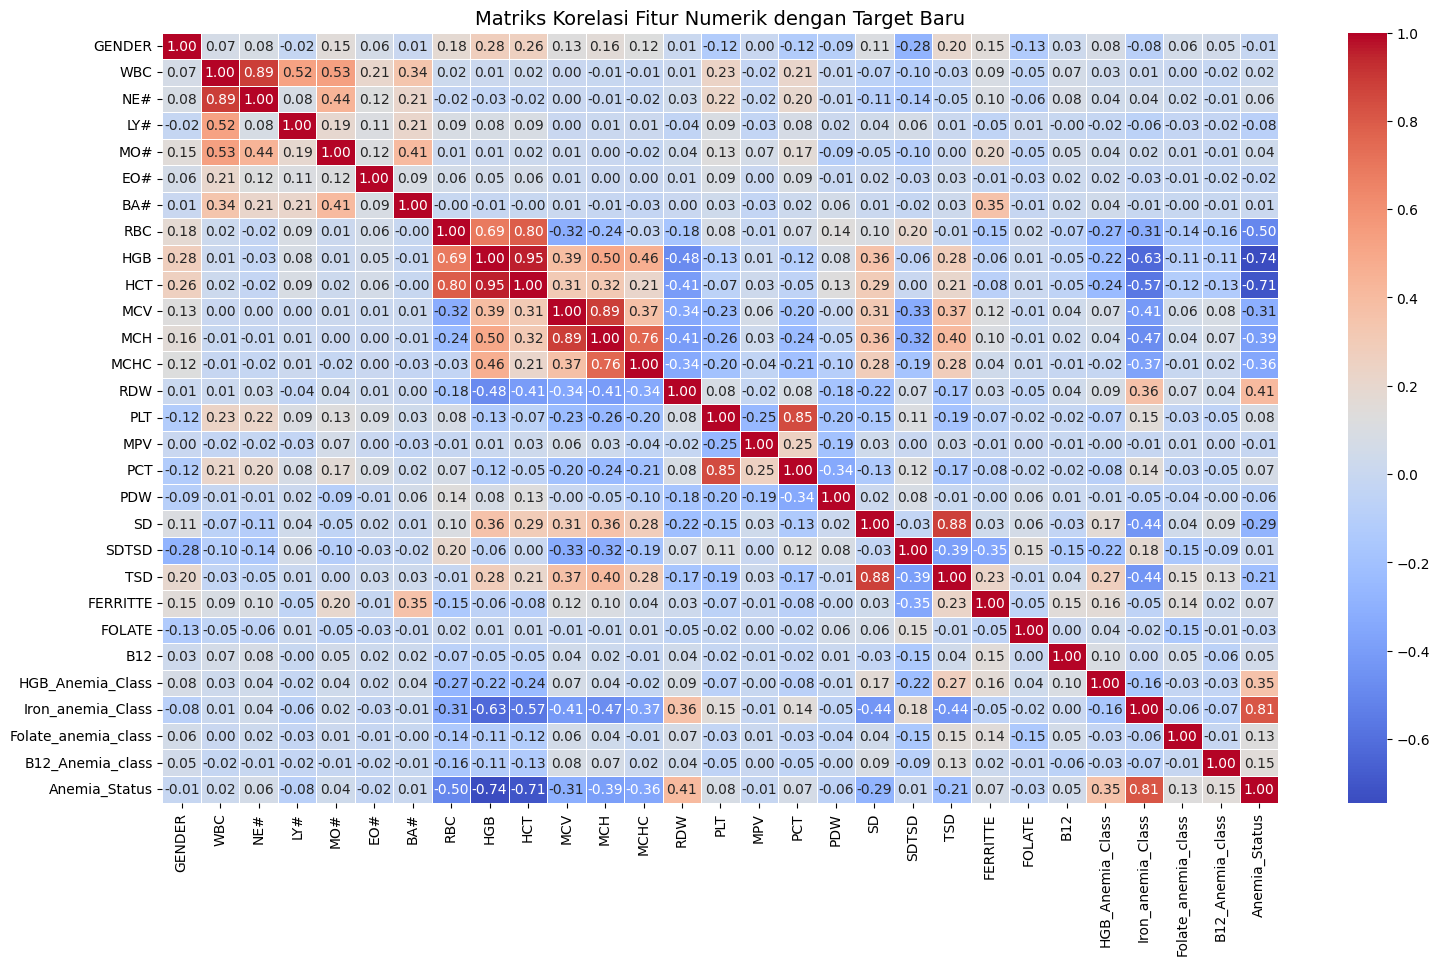

In [51]:
# Matriks Korelasi
if len(numeric_cols_eda) > 1:
    plt.figure(figsize=(18, 10))
    # Korelasi dengan target baru (setelah dipastikan target baru numerik)
    df_for_corr = df[numeric_cols_eda + [new_target_column]].copy()
    sns.heatmap(df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriks Korelasi Fitur Numerik dengan Target Baru', fontsize=14)
    plt.show()
else:
    print("Tidak cukup kolom numerik untuk plot matriks korelasi.")

# Feature Selection

In [52]:
# Kolom yang dikecualikan dari pemilihan fitur (label atau turunan)
features_to_exclude = [
    original_target_column, new_target_column,
    'HGB_Anemia_Class', 'Iron_anemia_Class',
    'Folate_anemia_class', 'B12_Anemia_class'
]
features_to_exclude = [col for col in features_to_exclude if col in df.columns]

In [53]:
features_df_for_selection = df.drop(columns=features_to_exclude, errors='ignore').copy()

In [54]:
# Encode sementara kolom kategorikal untuk korelasi
categorical_cols_for_corr = features_df_for_selection.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols_for_corr:
    features_df_for_selection[col] = LabelEncoder().fit_transform(features_df_for_selection[col].astype(str))


In [55]:
# Hitung korelasi dengan target baru
correlation_df_final = features_df_for_selection.copy()
correlation_df_final[new_target_column] = df[new_target_column]
correlations_with_target = correlation_df_final.corr(numeric_only=True)[new_target_column].abs().sort_values(ascending=False)


In [56]:
# Ambil 9 fitur dengan korelasi tertinggi (selain target itu sendiri)
final_selected_features = []
count = 0
for feature, correlation_value in correlations_with_target.items():
    if feature == new_target_column:
        continue
    if feature not in features_to_exclude:
        final_selected_features.append(feature)
        count += 1
    if count >= 9:
        break

In [57]:
if len(final_selected_features) < 9:
    print(f"Peringatan: Hanya {len(final_selected_features)} fitur ditemukan. Menambahkan fitur lain.")
    all_available_features = [col for col in df.columns if col not in features_to_exclude and col != new_target_column]
    for feature in all_available_features:
        if feature not in final_selected_features:
            final_selected_features.append(feature)
        if len(final_selected_features) >= 9:
            break

In [58]:
print(f"Jumlah fitur yang dipilih: {len(final_selected_features)}")
print(f"9 Fitur paling berpengaruh: {final_selected_features}")

Jumlah fitur yang dipilih: 9
9 Fitur paling berpengaruh: ['HGB', 'HCT', 'RBC', 'RDW', 'MCH', 'MCHC', 'MCV', 'SD', 'TSD']


# Data Preprocessing 

In [59]:
X = df[final_selected_features].copy()
y = df[new_target_column].copy()

In [60]:
# Identifikasi kolom kategorikal dan numerik di X yang sudah difilter
categorical_cols_final = [col for col in X.columns if X[col].dtype == 'object' or X[col].dtype == 'category']
print(f"Kolom kategorikal untuk encoding: {categorical_cols_final}")


Kolom kategorikal untuk encoding: []


In [61]:
label_encoders = {} # Simpan encoder
for col in categorical_cols_final:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [62]:
numeric_cols_for_scaling = [col for col in X.columns if col not in categorical_cols_final]
print(f"Kolom numerik untuk scaling: {numeric_cols_for_scaling}")

Kolom numerik untuk scaling: ['HGB', 'HCT', 'RBC', 'RDW', 'MCH', 'MCHC', 'MCV', 'SD', 'TSD']


In [63]:
scaler = StandardScaler() # Simpan scaler
X[numeric_cols_for_scaling] = scaler.fit_transform(X[numeric_cols_for_scaling])

# Train-Test Split dan SMOTE

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
print(f"\nUkuran data training sebelum SMOTE: {X_train.shape}")
print(f"Distribusi kelas training sebelum SMOTE:\n{pd.Series(y_train).value_counts()}")


Ukuran data training sebelum SMOTE: (12240, 9)
Distribusi kelas training sebelum SMOTE:
Anemia_Status
0    7798
1    4442
Name: count, dtype: int64


In [66]:
# Terapkan SMOTE pada data training
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [67]:
X_train = X_train_resampled
y_train = y_train_resampled

In [68]:
print(f"\nUkuran data training setelah SMOTE: {X_train.shape}")
print(f"Distribusi kelas training setelah SMOTE:\n{pd.Series(y_train).value_counts()}")


Ukuran data training setelah SMOTE: (15596, 9)
Distribusi kelas training setelah SMOTE:
Anemia_Status
1    7798
0    7798
Name: count, dtype: int64


# Model Building (Neural Network)

In [69]:
num_classes = len(np.unique(y_train))

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],), name='input_features'),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax', name='output_anemia_status')
])

print("\nModel Neural Network berhasil dibangun:")
model.summary()


Model Neural Network berhasil dibangun:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_anemia_status (Dense)    │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,450 (48.63 KB)

 Trainable params: 12,066 (47.13 KB)

 Non-trainable params: 384 (1.50 KB)

# Model Training

In [70]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

In [71]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8432 - loss: 0.3397 - val_accuracy: 0.9218 - val_loss: 0.2031
Epoch 2/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9100 - loss: 0.2028 - val_accuracy: 0.9205 - val_loss: 0.1719
Epoch 3/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9152 - loss: 0.1938 - val_accuracy: 0.9224 - val_loss: 0.1490
Epoch 4/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9253 - loss: 0.1738 - val_accuracy: 0.9212 - val_loss: 0.1466
Epoch 5/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9254 - loss: 0.1723 - val_accuracy: 0.9032 - val_loss: 0.1708
Epoch 6/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9265 - loss: 0.1586 - val_accuracy: 0.8808 - val_loss: 0.1784
Epoch 7/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9299 - loss: 0.1609 - val_accuracy: 0.9122 - val_loss: 0.1348
Epoch 8/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9329 - loss: 0.1567 - val_accu

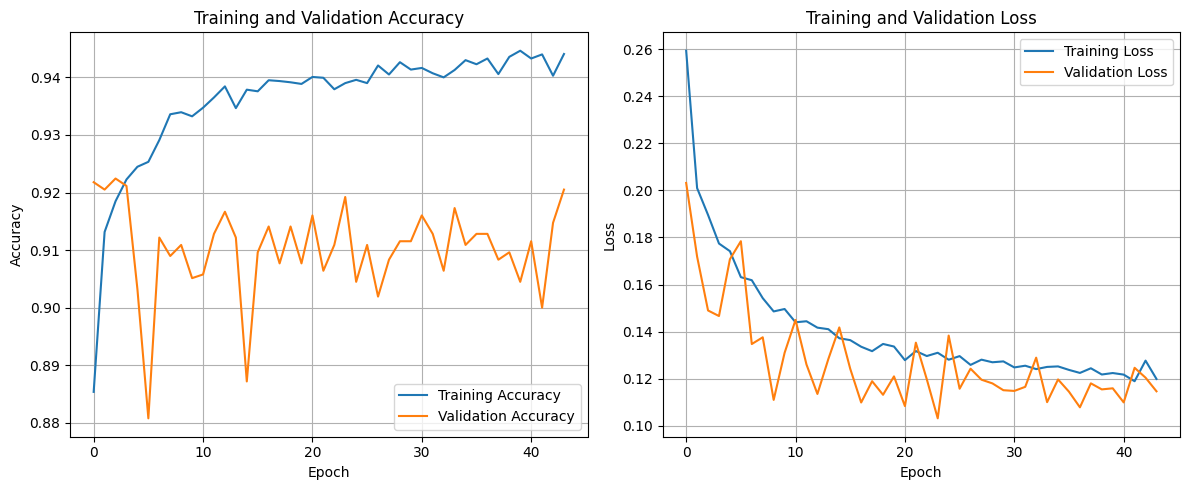

In [72]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Evaluation

In [73]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss pada data testing: {loss:.4f}")
print(f"Akurasi pada data testing: {accuracy:.4f}")

Loss pada data testing: 0.1218
Akurasi pada data testing: 0.9467


In [74]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


In [75]:
target_names_binary = ['Tidak Terkena Anemia', 'Terkena Anemia']
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test, y_pred, target_names=target_names_binary, zero_division=0))


--- Laporan Klasifikasi ---
                      precision    recall  f1-score   support

Tidak Terkena Anemia       0.95      0.97      0.96      1949
      Terkena Anemia       0.95      0.90      0.92      1111

            accuracy                           0.95      3060
           macro avg       0.95      0.94      0.94      3060
        weighted avg       0.95      0.95      0.95      3060



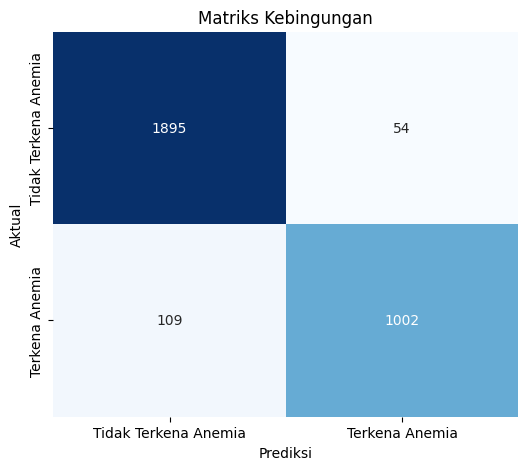

In [76]:
# Matriks Kebingungan
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names_binary, yticklabels=target_names_binary)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Kebingungan')
plt.show()

# Model Saving

In [77]:
try:
    # Jika dijalankan sebagai script .py
    current_script_path = os.path.dirname(os.path.abspath(__file__))
    PROJECT_ROOT = os.path.abspath(os.path.join(current_script_path, ''))
except NameError:
    # Jika dijalankan di Jupyter Notebook atau lingkungan interaktif serupa
    # Asumsikan notebook ada di 'capstone_model/notebooks/'
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ''))
    # Jika notebook Anda ada di root 'capstone_model', gunakan:
    # PROJECT_ROOT = os.getcwd()

ANEMIA_MODEL_ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, 'anemia-model', 'saved_model_anemia')

if not os.path.exists(ANEMIA_MODEL_ARTIFACTS_DIR):
    os.makedirs(ANEMIA_MODEL_ARTIFACTS_DIR)
    print(f"Direktori artefak dibuat: {ANEMIA_MODEL_ARTIFACTS_DIR}")
else:
    print(f"Direktori artefak sudah ada: {ANEMIA_MODEL_ARTIFACTS_DIR}")

# --- Simpan Artefak ---

# 1. Model Keras
anemia_model_path = os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_model.keras')
model.save(anemia_model_path)
print(f"Model Anemia disimpan di: {anemia_model_path}")

# 2. Scaler (StandardScaler)
# 'scaler' adalah objek StandardScaler yang sudah di-fit dari notebook Anda
scaler_path = os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler Anemia disimpan di: {scaler_path}")

# 3. Label Encoders (untuk fitur kategorikal)
# 'label_encoders' adalah dictionary {nama_kolom: objek_LabelEncoder} dari notebook Anda
label_encoders_path = os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_label_encoders.pkl')
joblib.dump(label_encoders, label_encoders_path)
print(f"Label encoders Anemia disimpan di: {label_encoders_path}")

# 4. Daftar Fitur Input yang Dipilih
input_features_ordered_path = os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_input_features_ordered.json')
with open(input_features_ordered_path, 'w') as f:
    json.dump(final_selected_features, f)
print(f"Daftar fitur input Anemia (ordered) disimpan di: {input_features_ordered_path}")

print("\n--- Penyimpanan Artefak Model Anemia Selesai ---")

# Referensi fitur input untuk API
print(f"\nFitur yang diharapkan API untuk model Anemia ({len(final_selected_features)} fitur):")
for feature_name in final_selected_features:
    original_dtype = df[feature_name].dtype
    print(f"- {feature_name} (Tipe data asli di dataset: {original_dtype})")

Direktori artefak sudah ada: /home/arch/DBS/capstone_model/anemia-model/saved_model_anemia
Model Anemia disimpan di: /home/arch/DBS/capstone_model/anemia-model/saved_model_anemia/anemia_model.keras
Scaler Anemia disimpan di: /home/arch/DBS/capstone_model/anemia-model/saved_model_anemia/anemia_scaler.pkl
Label encoders Anemia disimpan di: /home/arch/DBS/capstone_model/anemia-model/saved_model_anemia/anemia_label_encoders.pkl
Daftar fitur input Anemia (ordered) disimpan di: /home/arch/DBS/capstone_model/anemia-model/saved_model_anemia/anemia_input_features_ordered.json

--- Penyimpanan Artefak Model Anemia Selesai ---

Fitur yang diharapkan API untuk model Anemia (9 fitur):
- HGB (Tipe data asli di dataset: float64)
- HCT (Tipe data asli di dataset: float64)
- RBC (Tipe data asli di dataset: float64)
- RDW (Tipe data asli di dataset: float64)
- MCH (Tipe data asli di dataset: float64)
- MCHC (Tipe data asli di dataset: float64)
- MCV (Tipe data asli di dataset: float64)
- SD (Tipe data a

# Inference

In [78]:
# --- Muat Artefak ---
loaded_anemia_model = load_model(os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_model.keras'))
loaded_anemia_scaler = joblib.load(os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_scaler.pkl'))
loaded_anemia_label_encoders = joblib.load(os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_label_encoders.pkl'))
with open(os.path.join(ANEMIA_MODEL_ARTIFACTS_DIR, 'anemia_input_features_ordered.json'), 'r') as f:
    loaded_anemia_input_features = json.load(f)

print("Artefak model Anemia untuk inferensi berhasil dimuat.")

sample_raw_data = {
    "HGB": 11.0,      # Example value for Haemoglobin
    "HCT": 33.0,      # Example value for Hematocrit
    "RBC": 4.5,       # Example value for Red Blood Cell count
    "RDW": 15.0,      # Example value
    "MCH": 26.0,      # Example value
    "MCHC": 30.0,     # Example value
    "MCV": 80.0,      # Example value
    "SD": 3.5,        # Example value for SD (Standard Deviation of what? e.g. MCV's SD if RDW is CV)
    "TSD": 40.0       # Example value for TSD (Transferrin Saturation Denominator? or another SD?)
}

# Filter sample_raw_data agar hanya mengandung fitur yang ada di loaded_anemia_input_features
# dan pastikan urutannya benar
sample_input_dict = {feature: sample_raw_data.get(feature) for feature in loaded_anemia_input_features}
sample_df = pd.DataFrame([sample_input_dict])

# --- Preprocessing Data Contoh (mirip dengan yang akan dilakukan API) ---
# 1. Encode Fitur Kategorikal
anemia_categorical_cols_infer = list(loaded_anemia_label_encoders.keys())
for col in anemia_categorical_cols_infer:
    if col in sample_df.columns:
        le = loaded_anemia_label_encoders[col]
        # Pastikan input adalah string dan tangani nilai yang tidak dikenal jika perlu (meski idealnya tidak ada)
        try:
            sample_df[col] = le.transform(sample_df[col].astype(str))
        except ValueError as e:
            print(f"Error encoding '{col}': {e}. Nilai mungkin tidak ada dalam encoder. Kelas yang diketahui: {le.classes_}")
            # Anda mungkin ingin mengganti nilai tidak dikenal dengan mode atau nilai default
            # atau mengembalikan error. Untuk contoh ini, kita biarkan error terjadi.
            raise e


# 2. Scale Fitur Numerik
anemia_numeric_cols_infer = [col for col in loaded_anemia_input_features if col not in anemia_categorical_cols_infer]

# Pastikan semua kolom numerik adalah tipe numerik sebelum scaling
for col in anemia_numeric_cols_infer:
    if col in sample_df.columns:
        sample_df[col] = pd.to_numeric(sample_df[col], errors='coerce') # errors='coerce' akan mengubah non-numerik jadi NaN

# Cek NaN setelah konversi paksa ke numerik
if sample_df[anemia_numeric_cols_infer].isnull().any().any():
    print("Peringatan: Ada nilai non-numerik di kolom yang seharusnya numerik setelah konversi.")
    # Tangani NaN jika ada (misalnya, imputasi atau error)
    # Untuk contoh ini, kita asumsikan data input valid.

if anemia_numeric_cols_infer and not sample_df[anemia_numeric_cols_infer].empty:
     sample_df[anemia_numeric_cols_infer] = loaded_anemia_scaler.transform(sample_df[anemia_numeric_cols_infer])
else:
    print("Tidak ada fitur numerik untuk di-scale atau DataFrame fitur numerik kosong.")


# Pastikan urutan kolom sesuai dengan saat training
sample_df = sample_df[loaded_anemia_input_features]

# --- Lakukan Prediksi ---
prediction_probabilities = loaded_anemia_model.predict(sample_df)
predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0] # Ambil prediksi untuk baris pertama

# --- Interpretasi Hasil ---
anemia_status_map = {0: "Tidak Terkena Anemia", 1: "Terkena Anemia"} # Sesuai target_names_binary di notebook
predicted_status = anemia_status_map.get(predicted_class_index, "Status Tidak Diketahui")

print(f"\n--- Hasil Inferensi Anemia ---")
print(f"Data Input (setelah preprocessing):\n{sample_df.head()}")
print(f"Probabilitas Prediksi: {prediction_probabilities[0]}")
print(f"Indeks Kelas Prediksi: {predicted_class_index}")
print(f"Status Anemia Prediksi: {predicted_status}")

Artefak model Anemia untuk inferensi berhasil dimuat.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

--- Hasil Inferensi Anemia ---
Data Input (setelah preprocessing):
        HGB       HCT       RBC       RDW       MCH      MCHC       MCV  \
0 -0.849237 -1.063722 -0.285352  0.396067 -0.406255 -1.333674 -0.452818   

         SD       TSD  
0 -1.609351  1.526243  
Probabilitas Prediksi: [2.5882701e-07 9.9999976e-01]
Indeks Kelas Prediksi: 1
Status Anemia Prediksi: Terkena Anemia
